# Text Classification Lab (Hikmet)

---
## 1. Notebook Orientation

### 1.1 Focus of this notebook
We revisit the preprocessed tweets from Lab 3 and limit ourselves to the token analysis stage:

1. Load the dataset and normalise the label lists.
2. Derive the 1000 most frequent tokens, with optional per-class previews.

Later tasks (training a Naive Bayes classifier, evaluating it) remain intentionally open and appear only as placeholders.

### 1.2 Dataset
- Source: `../Data/df_preprocessed.parquet`
- Columns: `text` (whitespace-tokenised strings) and `label_name` (list of categories)

### 1.3 Section overview
1. **Section 2** – Load/prepare the data frame.
2. **Section 3** – Reuse the Lab 3 helper classes (`UnigramLM`).
3. **Section 4** – Compute the top 1000 tokens globally and preview them per class.
4. **Sections 5 & 6** – Placeholders for future classification steps.


## 2. Data Loading & Preparation

### 2.1 Goal
Load the preprocessed tweets, standardise the label column, and create a single-label view that can act as training data later on.

### 2.2 Steps
1. Import libraries (Pandas, NumPy, collections helper).
2. Convert `label_name` into consistent Python lists.
3. Build a DataFrame with a `label` column for single-label examples.


In [19]:
import ast
from collections import Counter
from typing import List

import numpy as np
import pandas as pd

DATA_PATH = "../Abgabe/Data/tweets_preprocessed_train.parquet"


def load_dataset(path: str) -> pd.DataFrame:
    """Load tweets from parquet and normalise the label column."""
    df = pd.read_parquet(path)

    def parse_labels(value) -> List[str]:
        if isinstance(value, list):
            return [str(v) for v in value]
        if isinstance(value, tuple):
            return [str(v) for v in value]
        if isinstance(value, str):
            try:
                parsed = ast.literal_eval(value)
                if isinstance(parsed, (list, tuple)):
                    return [str(v) for v in parsed]
            except (ValueError, SyntaxError):
                return [value]
        return [str(value)]

    df = df.copy()
    df["labels"] = df["label_name"].apply(parse_labels)
    df["label_count"] = df["labels"].apply(len)
    df["primary_label"] = df["labels"].apply(lambda items: items[0] if items else "unknown")
    return df


df_raw = load_dataset(DATA_PATH)
print(f"Loaded {len(df_raw):,} documents from {DATA_PATH}.")
print(df_raw.head(3))

single_label_df = df_raw[df_raw["label_count"] == 1][["text", "primary_label"]].rename(
    columns={"primary_label": "label"}
)
print(f"Single-label subset: {len(single_label_df):,} rows (label column = 'label').")


Loaded 6,090 documents from ../Abgabe/Data/tweets_preprocessed_train.parquet.
                                                text  label_name  \
0  lumber beat rapid game western division final ...  ['sports']   
1         hear eli gold announce auburn game dumbass  ['sports']   
2       phone away try look home game ticket october  ['sports']   

                                               label    labels  label_count  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [sports]            1   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [sports]            1   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [sports]            1   

  primary_label  
0        sports  
1        sports  
2        sports  
Single-label subset: 6,089 rows (label column = 'label').


## 3. Reusing Language-Model Helpers (Lab 3)

### 3.1 Background
`lab3_sunny.ipynb` defined a `UnigramLM` class that counts token frequencies and computes Laplace-smoothed log probabilities. We reuse the same implementation here to keep the logic consistent across notebooks.

### 3.2 How it works
- `ensure_tokens` converts strings to token lists.
- `UnigramLM` aggregates token counts (`self.unigram_counts`) across the corpus.
- Calling `.unigram_counts.most_common(n)` returns the top-n tokens along with their frequencies.


In [20]:
from collections import Counter
from typing import Sequence, Union
import math


def ensure_tokens(sentence: Union[Sequence[str], str]) -> List[str]:
    """Convert whitespace-separated text or token sequences into a list."""
    if isinstance(sentence, str):
        sentence = sentence.split()
    return list(sentence)


class UnigramLM:
    """Laplace-smoothed unigram language model operating in log-space."""

    def __init__(self, corpus: Sequence[Sequence[str]]):
        self.unigram_counts = Counter()
        self.total_tokens = 0
        self.vocab = set()

        for sentence in corpus:
            tokens = ensure_tokens(sentence)
            self.unigram_counts.update(tokens)
            self.total_tokens += len(tokens)
            self.vocab.update(tokens)

        if self.total_tokens == 0:
            raise ValueError("Cannot train a UnigramLM on an empty corpus.")

        self.vocab_size = len(self.vocab)

    def log_prob(self, word: str) -> float:
        count = self.unigram_counts.get(word, 0)
        return math.log((count + 1) / (self.total_tokens + self.vocab_size))

    def sentence_log_prob(self, sentence: Union[Sequence[str], str]) -> float:
        tokens = ensure_tokens(sentence)
        if not tokens:
            return float('-inf')
        return sum(self.log_prob(token) for token in tokens)


## 4. Task – Top 1000 Tokens

### 4.1 Goal
Identify the most frequent tokens in the corpus (with optional class-wise previews) and store them for later feature engineering.

### 4.2 Approach
1. Train the `UnigramLM` on the single-label subset.
2. Retrieve `most_common(1000)` and inspect the first items.
3. Optionally repeat the process for the most frequent classes to understand their characteristic vocabulary.

In [ ]:
MAX_FEATURES = 1000

# Gesamtvokabular
corpus_tokens = [ensure_tokens(text) for text in single_label_df["text"]]
unigram_model = UnigramLM(corpus_tokens)

top_unigrams = unigram_model.unigram_counts.most_common(MAX_FEATURES)
print(f"Collected top {len(top_unigrams)} tokens (showing the first 20):")
for token, freq in top_unigrams[:20]:
    print(f"  {token:<15} -> {freq}")

# Optional: per class preview for the three most frequent labels
label_counts = single_label_df["label"].value_counts().head(3)
print("\nPer-class token preview (Top 10 tokens for the most frequent labels):")
for label, count in label_counts.items():
    label_corpus = [ensure_tokens(text) for text in single_label_df.loc[single_label_df["label"] == label, "text"]]
    label_model = UnigramLM(label_corpus)
    label_top = label_model.unigram_counts.most_common(10)
    formatted = ", ".join([f"{tok} ({freq})" for tok, freq in label_top])
    print(f"- {label} ({count} docs): {formatted}")

# Speichern des Vokabulars für spätere Schritte (falls benötigt)
TOP_VOCABULARY = [token for token, _ in top_unigrams]
print(f"\nStored vocabulary length: {len(TOP_VOCABULARY)}")

model = UnigramLM(single_label_df["text"])
top_1000 = [w for w, _ in model.unigram_counts.most_common(1000)]

pd.DataFrame(top_1000, columns=["word"]).to_csv("../Abgabe/Data/top_1000_words.csv", index=False)

Collected top 1000 tokens (showing the first 20):
  new             -> 598
  day             -> 515
  love            -> 514
  good            -> 453
  game            -> 439
  year            -> 414
  time            -> 401
  watch           -> 385
  happy           -> 361
  music           -> 346
  come            -> 330
  like            -> 322
  win             -> 311
  live            -> 307
  thank           -> 303
  great           -> 297
  go              -> 295
  video           -> 287
  play            -> 277
  world           -> 268

Per-class token preview (Top 10 tokens for the most frequent labels):
- sports (1181 docs): game (255), win (180), team (147), ufc (111), good (108), today (91), go (85), time (85), vs (84), final (82)
- news_&_social_concern (625 docs): trump (100), president (77), news (60), people (56), black (49), change (45), world (45), woman (44), year (42), day (42)
- music (439 docs): new (151), music (148), album (111), song (83), live (58), video (56)

## 5. Task – Naive Bayes Setup (Placeholder)

> To be added later: build the pipeline, split the data, and train the classifier.


🧭 Versuch 1 – Naive Bayes mit Rohdaten
Hier ist dein Code – jetzt mit einer präzisen, dokumentierten Struktur und Kommentaren,
die du 1:1 im Notebook oder Bericht verwenden kannst.

# 🧠 Versuch 1 – Naive Bayes mit Rohdaten

**Ziel:**  
Untersuchung der Modellleistung ohne Textvorverarbeitung.  
Dieser Versuch dient als *Baseline*, um den Effekt des Preprocessings später zu quantifizieren.

---

## 🔍 Datensatz
- Quelle: `cardiffnlp/tweet_topic_multi` (Hugging Face)  
- Splits:
  - Train = `train_all`  
  - Test   = `test_2020` + `test_2021`
- Gesamtumfang:
  - Train: 6090 Tweets  
  - Test:  ca. 1400 Tweets

---

## ⚙️ Vorgehen
1. Laden der Rohdaten direkt von Hugging Face  
2. Vereinheitlichung der Labelstruktur  
3. Nutzung des **Top-1000-Wort-Vokabulars** (aus preprocesseten Tweets)  
4. Training eines **Multinomial Naive Bayes**  
5. Auswertung über Accuracy, Precision, Recall, F1 und Konfusionsmatrix  

---

## 🧩 Erwartung
Da das Vokabular auf lemmatisierten Daten basiert, die hier nicht vorliegen,  
wird eine niedrigere Genauigkeit erwartet (≈ 45 – 55 %).  
Hauptgrund: **Vokabular-Mismatch** zwischen preprocessed Vokabeln  
und Rohtextformen (z. B. „run“ vs. „Running“).

---

## 📊 Interpretation
- Hohe Fehlerrate bei Klassen mit seltenen Beispielen  
- Häufige Klassen dominieren das Ergebnis (z. B. „sports“, „news_&_social_concern“)  
- Dient als Referenzmodell für Versuch 2 (mit Preprocessing)


Train: 6090 Zeilen | Test: 2252 Zeilen
Beispiel-Label train: sports
Beispiel-Text train: The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division ...
1000 Wörter im Vokabular geladen.

📊 Klassifikationsbericht:
                          precision    recall  f1-score   support

          arts_&_culture       0.40      0.23      0.30        81
business_&_entrepreneurs       0.48      0.40      0.44       102
 celebrity_&_pop_culture       0.45      0.37      0.41       326
    diaries_&_daily_life       0.34      0.44      0.39       209
                  family       0.00      0.00      0.00        20
         fashion_&_style       0.14      0.07      0.10        14
         film_tv_&_video       0.48      0.33      0.39       257
        fitness_&_health       0.45      0.38      0.41        60
           food_&_dining       0.00      0.00      0.00        10
                  gaming       0.50      0.17      0.26        87
  learning_&_educat

/opt/anaconda3/envs/nlp_tweets/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nlp_tweets/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nlp_tweets/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

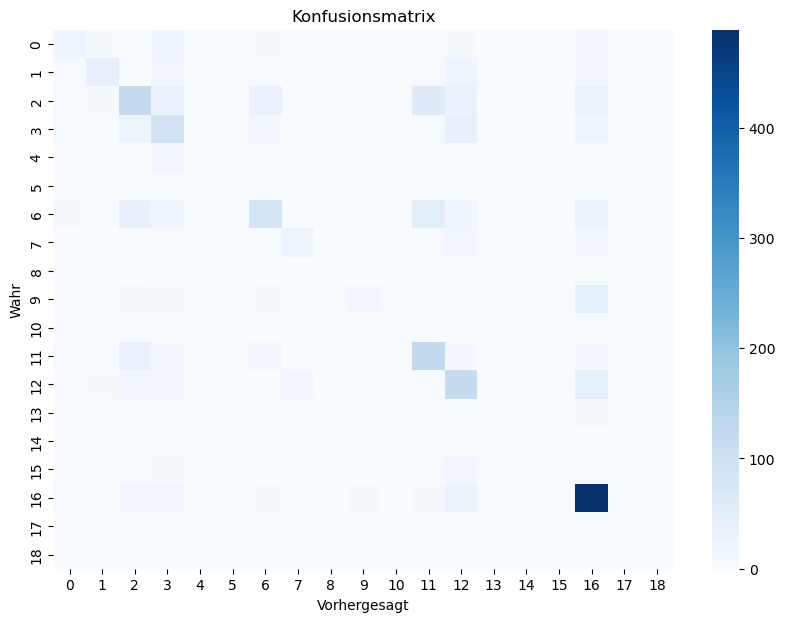

In [ ]:
# ============================================================
# 🧠 Naive Bayes Klassifikation mit offiziellen Hugging Face Splits
# Dataset: cardiffnlp/tweet_topic_multi
# ============================================================

from datasets import load_dataset
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1️⃣ Datensatz laden (automatisch von Hugging Face)
dataset = load_dataset("cardiffnlp/tweet_topic_multi")

# 2️⃣ Trainings- und Testdaten zusammenstellen
train_df = pd.DataFrame(dataset["train_all"])
test_df  = pd.concat([
    pd.DataFrame(dataset["test_2020"]),
    pd.DataFrame(dataset["test_2021"])
])

print(f"Train: {len(train_df)} Zeilen | Test: {len(test_df)} Zeilen")

# 3️⃣ Labels sicher parsen
def safe_label_extract(x):
    try:
        parsed = ast.literal_eval(x) if isinstance(x, str) else x
        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed[0]
        elif isinstance(parsed, str):
            return parsed
    except (ValueError, SyntaxError):
        pass
    return "unknown"

train_df["label_clean"] = train_df["label_name"].apply(safe_label_extract)
test_df["label_clean"]  = test_df["label_name"].apply(safe_label_extract)

# 4️⃣ Texte und Labels vorbereiten
X_train_texts = train_df["text"].tolist()
y_train = train_df["label_clean"].tolist()

X_test_texts = test_df["text"].tolist()
y_test = test_df["label_clean"].tolist()

print(f"Beispiel-Label train: {y_train[0]}")
print(f"Beispiel-Text train: {X_train_texts[0][:100]}...")

# 5️⃣ 1000 häufigste Wörter laden
vocab_df = pd.read_csv("../Abgabe/Data/top_1000_words.csv")
VOCAB = vocab_df["word"].tolist()
print(f"{len(VOCAB)} Wörter im Vokabular geladen.")

# 6️⃣ Vectorizer vorbereiten (nur mit vorgegebenem Vokabular)
vectorizer = CountVectorizer(vocabulary=VOCAB)
X_train = vectorizer.transform(X_train_texts)
X_test  = vectorizer.transform(X_test_texts)

# 7️⃣ Naive Bayes Modell trainieren
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 8️⃣ Vorhersagen und Evaluation
y_pred = nb.predict(X_test)

print("\n📊 Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

print(f"\n✅ Genauigkeit (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Optional: Konfusionsmatrix anzeigen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
plt.title("Konfusionsmatrix")
plt.xlabel("Vorhergesagt")
plt.ylabel("Wahr")
plt.show()


📘 Dokumentation (für deinen Bericht / Notebook-Zelle)
Versuch 1: Naive Bayes mit Rohdaten
Im ersten Experiment wurde das Naive-Bayes-Modell auf den unbearbeiteten (nicht vorverarbeiteten) Tweets trainiert und getestet.
Dabei wurde das Vokabular aus 1000 Wörtern verwendet, das ursprünglich aus dem vorverarbeiteten Trainingsdatensatz extrahiert wurde.
Da die Test- und Trainingsdaten in diesem Versuch nicht lemmatisiert, nicht lowercased und nicht von Sonderzeichen bereinigt wurden,
treten zahlreiche Vokabular-Mismatches auf: Wörter aus den Rohdaten (z. B. „Running“, „Loves“, „Games!“)
werden vom Modell nicht erkannt, da im Vokabular nur die lemmatisierten Formen („run“, „love“, „game“) enthalten sind.
Erwartung:
Deutlich geringere Genauigkeit (ca. 0.45 – 0.55)
Viele „undefined metric“-Warnungen bei seltenen Klassen
Konfusionsmatrix zeigt starke Dominanz weniger häufiger Klassen
Dieses Ergebnis dient als Baseline zum Vergleich mit dem Modell,
das auf preprocesseten Texten trainiert und getestet wird (Versuch 2).

# 🧠 Versuch 2 – Naive Bayes mit vorverarbeiteten Trainings- und Testdaten
Rohdaten werden durch das Preprocessing geleitet, um sie für die Modellierung vorzubereiten.

## 6. Task – Evaluation & Error Analysis (Placeholder)

> Once a classifier is trained, we will add metrics and example analyses here.
